## Calculate the IPO as per Screen & Deser 2019

In [1]:
import xarray as xr
import numpy as np
import datetime
import os
import glob
import scipy.signal as signal
import scipy
print(datetime.datetime.now())

2025-05-11 16:27:06.905068


In [3]:
model_names = [
    'ACCESS-ESM1-5', 'CanESM2', 'CanESM5', 'CESM1', 'CESM2-LENS', 
    'EC-Earth3', 'GFDL-ESM2M', 'MIROC6', 'MPI-ESM1', 'MPI-ESM1-2-LR'
]

In [4]:
EC_hist_mem = [
    i for i in np.sort(os.listdir('/glade/collections/cmip/CMIP6/CMIP/EC-Earth'\
            '-Consortium/EC-Earth3/historical/'))  if i[4] !='i' ]

EC_hist_ts_paths = {}
for i in EC_hist_mem:
    
    if i == 'r3i1p1f1':
        continue #corrupted files
    
    EC_hist_ts_paths[i] = []
    
    all_files = glob.glob(
        '/glade/collections/cmip/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/'\
        f'historical/{i}/Amon/ts/gr/*/ts/*.nc')
    
    for year_ in np.arange(1850,2015):
        if [s for s in all_files if f'{year_}01' in s]:
            if i == 'r2i1p1f1' : #corrupted files in v20194008?
                try:
                    EC_hist_ts_paths[i].append([s for s in all_files if f'{year_}01' in s][-1])
                except IndexError:
                    EC_hist_ts_paths[i].append([s for s in all_files if f'{year_}01' in s][0])
                    
            elif i == 'r21i1p1f1':
                EC_hist_ts_paths[i].append([s for s in all_files if f'{year_}01' in s][-1])
            else:
                EC_hist_ts_paths[i].append([s for s in all_files if f'{year_}01' in s][0])
        else:
            print(i, year_)

r11i1p1f1 1850
r13i1p1f1 1850
r15i1p1f1 1850


In [15]:
# for i in EC_hist_mem:
#     all_files = glob.glob(
#         '/glade/collections/cmip/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/'\
#         f'historical/{i}/Omon/tos/gn/*/tos/*.nc')
    
#     for year_ in np.arange(1850,2015):
#         if [s for s in all_files if f'{year_}01' in s]:
#             pass
#         else:
#             print(i, year_)

In [268]:
lat_dict = {'T1':[25,45], 'T2':[-10,10], 'T3':[-50,-15]}
lon_dict = {'T1':[140,215], 'T2':[170,270], 'T3':[150,200]}
base_LE = '/glade/collections/cdg/data/CLIVAR_LE/'

for model_name in ['EC-Earth3-historical']:#model_names:
    for region_ in ['T1','T2','T3']:
        
        print('\n', datetime.datetime.now(), model_name, region_)
        # if len(glob.glob(f'/glade/work/cwpowell/ice-free/IPO/{model_name}_SST_'\
        # f'annual_average_ensemble_anomaly_region_{region_}.nc')) > 0:
        #     continue

        ############################# ACCESS-ESM1-5 ############################
        if model_name == 'ACCESS-ESM1-5':

            sftlf = xr.open_dataset(
                '/glade/work/cwpowell/Data/CMIP6_sftlf/sftlf_'\
                'fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc')

            mem_list = np.sort(os.listdir('/glade/collections/cmip/CMIP6/CMIP/'\
                'CSIRO/ACCESS-ESM1-5/historical/'))

            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem0 = xr.open_dataset(glob.glob(f'/glade/collections/cmip/'\
                    f'CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/{mem_}/Amon/'\
                    'ts/gn/*/ts/*.nc')[0])
                ts_mem1 = xr.open_dataset('/glade/scratch/cwpowell/'\
                    f'ACCESS-ESM1-5/{mem_}/ts_Amon_ACCESS-ESM1-5_ssp370_'\
                    f'{mem_}_gn_201501-210012.nc')
                ts_mem = xr.concat((ts_mem0, ts_mem1),dim='time').sortby('time')

                ts_mem['time'] = np.arange('1850-01', '2101-01', 
                                           dtype='datetime64[M]')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time') #annual mean

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1]))) 

        ############################## CanESM2 ##############################    
        elif model_name == 'CanESM2':

            sftlf = xr.open_dataset(base_LE+'canesm2_lens/fx/sftlf/sftlf_fx_'\
                                    'CanESM2_historical_r0i0p0.nc')

            mem_list = np.arange(1,51)
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem = xr.open_dataset(base_LE+'canesm2_lens/Amon/ts/ts_Amon'\
                    f'_CanESM2_historical_rcp85_r{mem_}i1p1_195001-210012.nc')

                ts_mem['time'] = np.arange('1950-01', '2101-01', 
                                            dtype='datetime64[M]')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1])))

        ############################## CanESM5 ##############################    
        elif model_name == 'CanESM5':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/sft'\
                                    'lf_fx_CanESM5_historical_r1i1p1f1_gn.nc')

            mem_list = list(np.sort(os.listdir(
                '/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/historical/'))
                           )
            sst_region = []
            mem_used = []
            for mem_ in mem_list:
                print(mem_, end=",")
                try:
                    ts_mem0 = xr.open_dataset('/glade/collections/cmip/CMIP6/'\
                        f'CMIP/CCCma/CanESM5/historical/{mem_}/Amon/ts/gn/'\
                        f'v20190429/ts/ts_Amon_CanESM5_historical_{mem_}_gn_'\
                        '185001-201412.nc')
                    ts_mem1 = xr.open_dataset('/glade/collections/cmip/CMIP6/'\
                        f'ScenarioMIP/CCCma/CanESM5/ssp370/{mem_}/Amon/ts/gn/'\
                        f'v20190429/ts/ts_Amon_CanESM5_ssp370_{mem_}_gn_'\
                        '201501-210012.nc')
                    ts_mem = xr.concat((ts_mem0, ts_mem1),dim='time').sortby(
                        'time')

                    ts_mem['time'] = np.arange('1850-01', '2101-01', 
                                               dtype='datetime64[M]')

                    sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                    sst = sst.groupby('time.year').mean('time')

                    sst_region.append(sst.sel(
                        lon=slice(lon_dict[region_][0],
                                  lon_dict[region_][1])).sel(
                        lat=slice(lat_dict[region_][0],
                                  lat_dict[region_][1]))) 

                    mem_used.append(mem_)

                except FileNotFoundError:
                    print(mem_, 'NO FILE FOUND')

            mem_list = mem_used.copy()

        ############################## CESM1 ##############################        
        elif model_name == 'CESM1':

            sftlf = xr.open_dataset(base_LE+'cesm_lens/fx/sftlf/sftlf_fx_'\
                                    'CESM1-CAM5_historical_r0i0p0.nc')

            mem_list = np.arange(1,41)
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                if mem_ == 1:
                    start_yr = 1850
                else:
                    start_yr = 1920

                ts_mem = xr.open_dataset(
                    base_LE+'cesm_lens/Amon/ts/ts_Amon_CESM1-CAM5_historical_'\
                    f'rcp85_r{mem_}i1p1_{start_yr}01-210012.nc')

                ts_mem['time'] = np.arange(str(start_yr)+'-01', '2101-01', 
                                           dtype='datetime64[M]')

                if mem_ == 1: 
                    ts_mem = ts_mem.sel(time=slice('1920','2100')).sortby(
                        'time')
                else:
                    ts_mem = ts_mem.sortby('time')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1]))
                )

        ########################### CESM2-LENS ############################
        elif model_name == 'CESM2-LENS':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/'\
                                    'sftlf_fx_CESM2_historical_r1i1p1f1_gn.nc')

            mem_list = []
            for i in glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'\
                               'atm/proc/tseries/month_1/TS/*185001-185912.nc'):
                mem_list.append(i.split('LE2-')[1].split('.cam')[0])

            mem_list = np.sort(mem_list)
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem = xr.open_mfdataset('/glade/campaign/cgd/cesm/CESM2-LE/'\
                    'timeseries/atm/proc/tseries/month_1/TS/b.e21.*.f09_g17.'\
                    f'LE2-{mem_}.cam.h0.TS*.nc', combine='nested', 
                    concat_dim='time', chunks=None)

                ts_mem = ts_mem.sortby('time')

                ts_mem['time'] = np.arange('1850-01', '2101-01', 
                                           dtype='datetime64[M]')

                sst = ts_mem['TS'].where((sftlf['sftlf'].values)==0).load()
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1])))

        ############################## EC-Earth3 ##############################    
        elif model_name == 'EC-Earth3':

            mem_list = [f'r{i}i1p1f1' for i in range(101,151)]

            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                tos_mem_hist = xr.open_mfdataset('/glade/scratch/cwpowell/'\
                    f'EC-Earth3/{mem_}/*.nc', combine='nested',
                    concat_dim='time', chunks=None)
                tos_mem_fut = xr.open_mfdataset('/glade/scratch/cwpowell/'\
                    f'EC-Earth3/ssp370/{mem_}/*.nc', combine='nested',
                    concat_dim='time', chunks=None)
                tos_mem = xr.concat((tos_mem_hist,tos_mem_fut),dim='time')

                tos_mem = tos_mem.sortby('time').load()

                tos_mem['time'] = np.arange('1970-01', '2101-01', 
                                               dtype='datetime64[M]')
                sst = tos_mem['tos'].groupby('time.year').mean('time')

                sst_lat = sst['latitude'].copy()
                sst_lon = sst['longitude'].copy()
                sst = sst.where(
                    np.logical_and(sst_lon >= lon_dict[region_][0],
                                   sst_lon <= lon_dict[region_][1]))

                sst_region.append(sst.where(
                    np.logical_and(sst_lat >= lat_dict[region_][0],
                                   sst_lat <= lat_dict[region_][1]), drop=True))

                
        ############################## EC-Earth3 ##############################    
        elif model_name == 'EC-Earth3-historical':

            sftlf = xr.open_dataset('/glade/collections/cmip/CMIP6/ScenarioMIP'\
                '/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/fx/sftlf/gr/'\
                'v20190927/sftlf/sftlf_fx_EC-Earth3_ssp370_r1i1p1f1_gr.nc')
            
            sftlf = sftlf.drop('lat_bnds').drop('lon_bnds')
            sftlf['lat'] = np.round(sftlf['lat'],3)
            sftlf['lon'] = np.round(sftlf['lon'],3)
            
            mem_list = np.sort(list(EC_hist_ts_paths.keys()))
            
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")                

                ts_mem = xr.open_mfdataset(
                    EC_hist_ts_paths[mem_], combine='nested', concat_dim='time',
                    chunks=None)
                
                ts_mem = ts_mem.drop('lon_bnds').drop('lat_bnds')

                ts_mem = ts_mem.sortby('time')
                ts_mem['lat'] = sftlf['lat']
                ts_mem['lon'] = sftlf['lon']
                
                try:
                    ts_mem['time'] = np.arange('1850-01', '2015-01', 
                                               dtype='datetime64[M]')
                except ValueError:
                    ts_mem['time'] = np.arange('1851-01', '2015-01', 
                                               dtype='datetime64[M]')

                try:
                    sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0).load()
                except ValueError: #extra lon or lat coordinates
                    if mem_ in ['r2i1p1f1','r21i1p1f1']:
                        sst = ts_mem['ts'].where(ts_mem['lon']==sftlf['lon'])
                        sst = sst.where((sftlf['sftlf'].values)==0).load()
                    else:
                        sst = ts_mem['ts'].where(ts_mem['lat']==sftlf['lat'])
                        sst = sst.where((sftlf['sftlf'].values)==0).load()
                    
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1])))

        ############################## GFDL-ESM2M ##############################    
        elif model_name == 'GFDL-ESM2M':

            sftlf = xr.open_dataset(base_LE+'gfdl_esm2m_lens/fx/sftlf/sftlf_'\
                                    'fx_GFDL-ESM2M_historical_r0i0p0.nc')

            mem_list = np.arange(1,31)
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem = xr.open_dataset(
                    base_LE+'gfdl_esm2m_lens/Amon/ts/ts_Amon_GFDL-ESM2M_'\
                    f'historical_rcp85_r{mem_}i1p1_195001-210012.nc')

                ts_mem['time'] = np.arange('1950-01', '2101-01', 
                                           dtype='datetime64[M]')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1])))

        ############################## MIROC6 ##############################    
        elif model_name == 'MIROC6':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/'\
                                    'sftlf_fx_MIROC6_historical_r1i1p1f1_gn.nc')

            mem_list = np.sort(os.listdir(
                '/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC6/historical/'))
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem0 = xr.open_mfdataset(glob.glob('/glade/scratch/'\
                    f'cwpowell/MIROC6/historical/{mem_}/*.nc'), 
                    combine='nested', concat_dim='time', chunks=None)
                ts_mem1 = xr.open_dataset('/glade/scratch/cwpowell/MIROC6/'\
                    f'{mem_}/ts_Amon_MIROC6_ssp370_{mem_}_gn_201501-210012.nc')
                ts_mem = xr.concat((ts_mem0.load(), ts_mem1),dim='time').sortby(
                    'time')

                ts_mem['time'] = np.arange('1850-01', '2101-01', 
                                           dtype='datetime64[M]')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1]))) 

        ############################## MPI-ESM1 ##############################    
        elif model_name == 'MPI-ESM1':

            sftlf = xr.open_dataset(base_LE+'mpi_lens/fx/sftlf/sftlf_fx_'\
                                    'MPI-ESM-MR_historical_r0i0p0.nc')

            mem_list = np.arange(1,101)
            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem = xr.open_dataset(
                    base_LE+'mpi_lens/Amon/ts/ts_Amon_MPI-ESM_historical_'\
                    f'rcp85_r{mem_}i1p1_185001-209912.nc')

                ts_mem['time'] = np.arange('1850-01', '2100-01', 
                                           dtype='datetime64[M]')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time')
                
                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1]))) 

        ############################ MPI-ESM1-2-LR #############################    
        elif model_name == 'MPI-ESM1-2-LR':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/'\
                'sftlf_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc')

            mem_list = [f'r{i}i1p1f1' for i in range(1,31)]

            sst_region = []
            for mem_ in mem_list:
                print(mem_, end=",")

                ts_mem_hist = xr.open_mfdataset(glob.glob('/glade/'\
                    f'scratch/cwpowell/MPI-ESM1-2-LR/historical/{mem_}/*.nc'),
                    combine='nested', concat_dim='time')
                ts_mem_fut = xr.open_mfdataset(glob.glob('/glade/scratch/'\
                    f'cwpowell/MPI-ESM1-2-LR/{mem_}/*.nc'), 
                    combine='nested', concat_dim='time')

                ts_mem = xr.concat((ts_mem_hist,ts_mem_fut),dim='time')

                ts_mem = ts_mem.sortby('time').load()

                ts_mem['time'] = np.arange('1850-01', '2101-01', 
                                               dtype='datetime64[M]')

                sst = ts_mem['ts'].where((sftlf['sftlf'].values)==0)
                sst = sst.groupby('time.year').mean('time')

                sst_region.append(sst.sel(
                    lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                    lat=slice(lat_dict[region_][0],lat_dict[region_][1])))

        ############################ Other GCM Name ############################
        else:
            print('unknown model name')

        ############################ save to NetCDF ############################   
        sst_region = xr.concat((sst_region), dim='member')
        sst_region['member'] = mem_list
        sst_anom = sst_region - sst_region.mean('member')
        sst_anom_xr = xr.Dataset({'sst':sst_anom})

        sst_anom_xr.to_netcdf(
            f'/glade/work/cwpowell/ice-free/IPO/{model_name}_'\
            f'SST_annual_average_ensemble_anomaly_region_{region_}.nc'
        )


 2023-09-13 16:58:01.259095 EC-Earth3-historical T1
r10i1p1f1,r11i1p1f1,r12i1p1f1,r13i1p1f1,r14i1p1f1,r15i1p1f1,r16i1p1f1,r17i1p1f1,r18i1p1f1,r19i1p1f1,r22i1p1f1,r23i1p1f1,r24i1p1f1,r25i1p1f1,r2i1p1f1,r4i1p1f1,r5i1p1f1,r6i1p1f1,r7i1p1f1,r9i1p1f1,
 2023-09-13 17:08:43.003177 EC-Earth3-historical T2
r10i1p1f1,r11i1p1f1,r12i1p1f1,r13i1p1f1,r14i1p1f1,r15i1p1f1,r16i1p1f1,r1i1p1f1,r20i1p1f1,r21i1p1f1,r22i1p1f1,r23i1p1f1,r24i1p1f1,r25i1p1f1,r2i1p1f1,r4i1p1f1,r5i1p1f1,r6i1p1f1,r7i1p1f1,r9i1p1f1,
 2023-09-13 17:19:12.076827 EC-Earth3-historical T3
r10i1p1f1,r11i1p1f1,r12i1p1f1,r13i1p1f1,r14i1p1f1,r15i1p1f1,r16i1p1f1,r17i1p1f1,r18i1p1f1,r19i1p1f1,r1i1p1f1,r20i1p1f1,r21i1p1f1,r22i1p1f1,r23i1p1f1,r24i1p1f1,r25i1p1f1,r2i1p1f1,r4i1p1f1,r5i1p1f1,r6i1p1f1,r7i1p1f1,r9i1p1f1,

In [73]:
areacella['lon'] = list(areacella['lon'][:199].values) + list(sst_anom['lon'].values) + list(areacella['lon'][306:].values)

In [74]:
region_area = areacella.where(sst_anom[0,20,:,:]>-999)

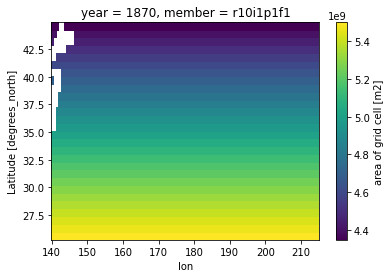

In [76]:
region_area.plot()

In [124]:
def adjust_lon_areacella(areacella, region_):
    
    if region_ == 'T1':
        areacella['lon'] = list(areacella['lon'][:199].values) \
        + list(sst_anom['lon'].values) + list(areacella['lon'][306:].values)
    elif region_ == 'T2':
        areacella['lon'] = list(areacella['lon'][:242].values) \
        + list(sst_anom['lon'].values) + list(areacella['lon'][384:].values)
    elif region_ == 'T3':
        areacella['lon'] = list(areacella['lon'][:213].values) \
        + list(sst_anom['lon'].values) + list(areacella['lon'][284:].values)
        
    return(areacella)

In [125]:
#define the lanczos smoothing weights for an 11-year period
lanczos_window = np.array(
    [3.89817183e-17, 2.33872321e-01, 5.04551152e-01, 7.56826729e-01,
     9.35489284e-01, 1.00000000e+00, 9.35489284e-01, 7.56826729e-01,
     5.04551152e-01, 2.33872321e-01, 3.89817183e-17,]
)

for model_name in ['EC-Earth3-historical']:#model_names:
    print(datetime.datetime.now(), model_name)
    
    if len(glob.glob(f'/glade/work/cwpowell/ice-free/IPO/{model_name}_'\
                     'annual_11yr_TPI.nc')) > 0:
        continue
   
    if model_name == 'EC-Earth3':
        areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
            f'CMIP6_areacello/areacello*{model_name}_*.nc')[0])['areacello']
    elif model_name in ['CESM1','CanESM2','GFDL-ESM2M','MPI-ESM1']:
        areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
            f'CMIP5_areacella/areacella*{model_name}_*.nc')[0])['areacella']
    elif model_name == 'EC-Earth3-historical':
        areacella = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_areacella'\
            '/areacella_fx_EC-Earth3_ssp370_r1i1p1f1_gn.nc')['cell_area']
        areacella['lat'] = np.round(areacella['lat'],3)
        areacella['lon'] = np.round(areacella['lon'],3)
    else:
        areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
            f'CMIP6_areacella/areacella*{model_name}_*.nc')[0])['areacella']
        
    anom_weight = {}
    
    for region_ in ['T1','T2','T3']:

        sst_anom = xr.open_dataset(
            f'/glade/work/cwpowell/ice-free/IPO/{model_name}_SST_annual_'
            f'average_ensemble_anomaly_region_{region_}.nc')['sst']
        
        #compute the 11-year running mean on the annual ensemble anomalies
        sst_anom = sst_anom.rolling(year=(11), center=True).mean()
        
        if model_name == 'EC-Earth3-historical':
            areacella = adjust_lon_areacella(areacella, region_)         

        try:
            region_area = areacella.where(sst_anom[0,20,:,:]>-999)
            
        except IndexError:
            #areacella and sst_anom latitudes do not exactly match
            areacella['lat'] = np.round(areacella['lat'],3)
            sst_anom['lat'] = np.round(sst_anom['lat'],3)
            region_area = areacella.where(sst_anom[0,20,:,:]>-999)
        
        sst_anom_weighted = (sst_anom * region_area) / region_area.sum()

        if model_name == 'EC-Earth3':
            anom_weight[region_] = sst_anom_weighted.mean('i').mean('j')
        else:
            anom_weight[region_] = sst_anom_weighted.mean('lat').mean('lon')
        
    TPI = anom_weight['T2'] - ((anom_weight['T1'] + anom_weight['T3'])/2)
    TPI_standard = (TPI-TPI.mean())/(TPI.std('year').mean('member'))
    
    TPI_standard.to_netcdf(
        f'/glade/work/cwpowell/ice-free/IPO/{model_name}_annual_11yr_TPI.nc')
    
    ### seems like Screen et al. (2019) didn't lowpass filter the timeseries
    TPI_filt = TPI_standard*0 + signal.filtfilt(lanczos_window, 1, TPI_standard)
    TPI_filt = TPI_filt/TPI_filt.std('year').mean('member')
    
    TPI_filt.to_netcdf(
        f'/glade/work/cwpowell/ice-free/IPO/{model_name}_annual_11yr_TPI'\
        '_Lanczos_filter_11yr.nc')

2023-09-14 10:45:28.459658 EC-Earth3-historical
T1
T2
T3


In [134]:
TPI_filt.to_netcdf(
        f'/glade/work/cwpowell/ice-free/IPO/{model_name}_annual_11yr_TPI'\
        '_Lanczos_filter_11yr_new.nc')
    

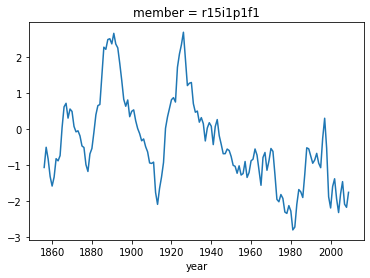

In [132]:
TPI_standard.isel(member=5).plot()

## Calculate the TPI IPO on the Pre-Industrial Control Simulations

In [92]:
#load the PI Control data
PI_paths = {
    'ACCESS-ESM1-5':'/glade/work/cwpowell/ice-free/raw_SST/ACCESS-ESM1-5/piControl/',
    'CanESM2':'/glade/collections/cmip/cmip5/output1/CCCma/CanESM2/piControl/mon/ocean/Omon/r1i1p1/v20120410/tos/',
    'CanESM5':'/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/ts/gn/v20190429/ts/',
    'CESM1':'/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/TS/b.e11.B1850C5CN.f09_g16.005.cam.h0.TS.',
    'CESM2-LENS':'/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ts/gn/files/d20190320/',
    'EC-Earth3':'/glade/collections/cmip/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/piControl/r1i1p1f1/Amon/ts/gr/v20190712/ts/',
    # 'EC-Earth3':'/glade/work/cwpowell/ice-free/raw_SST/EC-Earth3/',
    'GFDL-ESM2M':'/glade/collections/cmip/cmip5/output1/NOAA-GFDL/GFDL-ESM2M/piControl/mon/ocean/Omon/r1i1p1/v20130226/tos/',
    'MIROC6':'/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC6/piControl/r1i1p1f1/Amon/ts/gn/v20181212/ts/',
    'MPI-ESM1':'/glade/collections/cmip/cmip5/output1/MPI-M/MPI-ESM-LR/piControl/mon/ocean/Omon/r1i1p1/v20120625/tos/',
    'MPI-ESM1-2-LR':'/glade/collections/cmip/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/ts/gn/v20190710/ts/',
}

In [32]:
def TPI_region(model_name):
    
    ts_pi = xr.open_mfdataset(
        glob.glob(PI_paths[model_name]+'*.nc'), combine='nested', 
        concat_dim='time', chunks=None
    )
    
    ts_pi['time'] = xr.cftime_range(
        start='0001-01', periods=int(len(ts_pi['time'])), 
        freq='M', calendar='noleap')
    
    sst = ts_pi['ts'].where((sftlf['sftlf'].values)==0)
    sst = sst.sortby('time').groupby('time.year').mean('time') 

    sst_region = sst.sel(
        lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
        lat=slice(lat_dict[region_][0],lat_dict[region_][1])) 

    return(sst_region)

In [76]:
def TPI_region_tos(model_name, lat_name, lon_name):
    
    tos_pi = xr.open_mfdataset(glob.glob(PI_paths[model_name]+'*.nc'), 
                               combine='nested', concat_dim='time')
        
    tos_pi['time'] = xr.cftime_range(
        start='0001-01', periods=int(len(tos_pi['time'])), 
        freq='M', calendar='noleap')
    
    sst = tos_pi.copy().sortby('time').groupby('time.year').mean('time') 
    
    sst_lat = sst[lat_name].copy()
    sst_lon = sst[lon_name].copy()
    
    if model_name == 'GFDL-ESM2M': #uses negative lon values in Pacific
        sst = sst.where(
            np.logical_and(sst_lon >= lon_dict[region_][0]-360,
                           sst_lon <= lon_dict[region_][1]-360))
    else:
        sst = sst.where(
            np.logical_and(sst_lon >= lon_dict[region_][0],
                           sst_lon <= lon_dict[region_][1]))

    sst_region = sst.where(
        np.logical_and(sst_lat >= lat_dict[region_][0],
                       sst_lat <= lat_dict[region_][1]), drop=True)

    return(sst_region)

In [80]:
lat_dict = {'T1':[25,45], 'T2':[-10,10], 'T3':[-50,-15]}
lon_dict = {'T1':[140,215], 'T2':[170,270], 'T3':[150,200]}

for model_name in model_names:
    for region_ in ['T1','T2','T3']:
        
        print(datetime.datetime.now(), model_name, region_)
        
        if len(glob.glob(f'/glade/work/cwpowell/ice-free/IPO/{model_name}_'\
            f'SST_annual_average_piControl_{region_}.nc')) > 0:
            continue

        ############################# ACCESS-ESM1-5 ############################
        if model_name == 'ACCESS-ESM1-5':

            sftlf = xr.open_dataset(
                '/glade/work/cwpowell/Data/CMIP6_sftlf/sftlf_'\
                'fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc')
            
            sst_region = TPI_region(model_name)
            
        ############################## CanESM2 #################################    
        elif model_name == 'CanESM2':

            sst_region = TPI_region_tos(model_name, 'lat', 'lon')

        ############################## CanESM5 #################################    
        elif model_name == 'CanESM5':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/sft'\
                                    'lf_fx_CanESM5_historical_r1i1p1f1_gn.nc')

            sst_region = TPI_region(model_name)
            
        ############################### CESM1 ##################################        
        elif model_name == 'CESM1':

            sftlf = xr.open_dataset(
                '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/fx/sftlf/'\
                'sftlf_fx_CESM1-CAM5_historical_r0i0p0.nc')

            ts_pi = xr.open_mfdataset(
                glob.glob(PI_paths[model_name]+'*.nc'), combine='nested', 
                concat_dim='time', chunks=None
            )

            sst = ts_pi['TS'].where((sftlf['sftlf'].values)==0)
            sst = sst.sortby('time').groupby('time.year').mean('time') 

            sst_region = sst.sel(
                lon=slice(lon_dict[region_][0],lon_dict[region_][1])).sel(
                lat=slice(lat_dict[region_][0],lat_dict[region_][1])) 

        ############################## CESM2-LENS ##############################
        elif model_name == 'CESM2-LENS':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/'\
                                    'sftlf_fx_CESM2_historical_r1i1p1f1_gn.nc')

            sst_region = TPI_region(model_name)

        ############################### EC-Earth3 ##############################    
        elif model_name == 'EC-Earth3':

            sftlf = xr.open_dataset('/glade/collections/cmip/CMIP6/ScenarioMIP'\
                '/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/fx/sftlf/gr/'\
                'v20190927/sftlf/sftlf_fx_EC-Earth3_ssp370_r1i1p1f1_gr.nc')
            
            sst_region = TPI_region(model_name)

        ############################## GFDL-ESM2M ##############################    
        elif model_name == 'GFDL-ESM2M':

            sst_region = TPI_region_tos(model_name, 'rlat', 'rlon')

        ################################ MIROC6 ################################    
        elif model_name == 'MIROC6':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/'\
                                    'sftlf_fx_MIROC6_historical_r1i1p1f1_gn.nc')

            sst_region = TPI_region(model_name)
            
        ############################### MPI-ESM1 ###############################
        elif model_name == 'MPI-ESM1':

            sst_region = TPI_region_tos(model_name, 'lat', 'lon')

        ############################ MPI-ESM1-2-LR #############################    
        elif model_name == 'MPI-ESM1-2-LR':

            sftlf = xr.open_dataset('/glade/work/cwpowell/Data/CMIP6_sftlf/'\
                'sftlf_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc')

            sst_region = TPI_region(model_name)

        ############################ Other GCM Name ############################
        else:
            print('unknown model name')

        ############################ save to NetCDF ############################   
        if model_name in ['CanESM2','GFDL-ESM2M','MPI-ESM1']:
            sst_region = sst_region['tos']
            
        sst_region_xr = xr.Dataset({'sst':sst_region})
        sst_region_xr.to_netcdf(
            f'/glade/work/cwpowell/ice-free/IPO/{model_name}_'\
            f'SST_annual_average_piControl_{region_}.nc'
        )

2023-09-09 15:29:51.521602 ACCESS-ESM1-5 T1
2023-09-09 15:29:51.521708 ACCESS-ESM1-5 T2
2023-09-09 15:29:51.521753 ACCESS-ESM1-5 T3
2023-09-09 15:29:51.521793 CanESM2 T1
2023-09-09 15:29:51.521832 CanESM2 T2
2023-09-09 15:29:51.521870 CanESM2 T3
2023-09-09 15:29:51.521909 CanESM5 T1
2023-09-09 15:29:51.521947 CanESM5 T2
2023-09-09 15:29:51.521988 CanESM5 T3
2023-09-09 15:29:51.522038 CESM1 T1
2023-09-09 15:29:51.522077 CESM1 T2
2023-09-09 15:29:51.522116 CESM1 T3
2023-09-09 15:29:51.522154 CESM2-LENS T1
2023-09-09 15:29:51.522193 CESM2-LENS T2
2023-09-09 15:29:51.522231 CESM2-LENS T3
2023-09-09 15:29:51.522270 EC-Earth3 T1
2023-09-09 15:29:51.522308 EC-Earth3 T2
2023-09-09 15:29:51.522345 EC-Earth3 T3
2023-09-09 15:29:51.522383 GFDL-ESM2M T1


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2023-09-09 15:30:11.164975 GFDL-ESM2M T2


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2023-09-09 15:30:30.903935 GFDL-ESM2M T3


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2023-09-09 15:30:51.607633 MIROC6 T1
2023-09-09 15:30:51.607780 MIROC6 T2
2023-09-09 15:30:51.607827 MIROC6 T3
2023-09-09 15:30:51.607870 MPI-ESM1 T1
2023-09-09 15:30:51.607912 MPI-ESM1 T2
2023-09-09 15:30:51.607953 MPI-ESM1 T3
2023-09-09 15:30:51.607994 MPI-ESM1-2-LR T1
2023-09-09 15:30:51.608048 MPI-ESM1-2-LR T2
2023-09-09 15:30:51.608091 MPI-ESM1-2-LR T3


In [21]:
#define the lanczos smoothing weights for an 11-year period
lanczos_window = np.array(
    [3.89817183e-17, 2.33872321e-01, 5.04551152e-01, 7.56826729e-01,
     9.35489284e-01, 1.00000000e+00, 9.35489284e-01, 7.56826729e-01,
     5.04551152e-01, 2.33872321e-01, 3.89817183e-17,]
)

for model_name in ['EC-Earth3']: #model_names:
    print(datetime.datetime.now(), model_name)
    
    # if len(glob.glob(f'/glade/work/cwpowell/ice-free/IPO/{model_name}_'\
    #                  'piControl_annual_11yr_TPI.nc')) > 0:
    #     continue
   
    if model_name == 'EC-Earth3': #top for r2i1p1f1, bottom r1i1p1f1
        areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
            f'CMIP6_areacella/areacella*{model_name}_*.nc')[0])['cell_area']
        # areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
        #     f'CMIP6_areacella/{model_name}_areacella_from_sftlf.nc')[0])['cell_area']
    elif model_name in ['CanESM2','GFDL-ESM2M','MPI-ESM1']:
        if model_name == 'MPI-ESM1':
            areacella = xr.open_dataset('/glade/work/cwpowell/Data/CMIP5_areac'\
            f'ello/areacello_fx_MPI-ESM-LR_historical_r0i0p0.nc')['areacello']
        else:
            areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
                f'CMIP5_areacello/areacello*{model_name}_*.nc')[0])['areacello']
    elif model_name == 'CESM1':
        areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
            f'CMIP5_areacella/areacella*{model_name}_*.nc')[0])['areacella']
    else:
        areacella = xr.open_dataset(glob.glob('/glade/work/cwpowell/Data/'\
            f'CMIP6_areacella/areacella*{model_name}_*.nc')[0])['areacella']
        
    anom_weight = {}

    for region_ in ['T1','T2','T3']:

        sst_anom = xr.open_dataset(
            f'/glade/work/cwpowell/ice-free/IPO/{model_name}_r2i1p1f1_'
            f'SST_annual_average_piControl_{region_}.nc')['sst']
        
        #compute the 11-year running mean on the annual ensemble anomalies
        sst_anom = sst_anom.rolling(year=(11), center=True).mean()

        try:
            region_area = areacella.where(sst_anom[20]>-999)
            
        except IndexError:
            #areacella and sst_anom latitudes do not exactly match
            areacella['lat'] = np.round(areacella['lat'],3)
            sst_anom['lat'] = np.round(sst_anom['lat'],3)
            areacella['lon'] = np.round(areacella['lon'],3)
            sst_anom['lon'] = np.round(sst_anom['lon'],3)
            region_area = areacella.where(sst_anom[20]>-999)

        sst_anom_weighted = (sst_anom * region_area) / region_area.sum()

        if model_name in ['MPI-ESM1']:
            anom_weight[region_] = sst_anom_weighted.mean('i').mean('j')
        elif model_name in ['GFDL-ESM2M']:
            anom_weight[region_] = sst_anom_weighted.mean('rlat').mean('rlon')
        else:
            anom_weight[region_] = sst_anom_weighted.mean('lat').mean('lon')
        
    TPI = anom_weight['T2'] - ((anom_weight['T1'] + anom_weight['T3'])/2)
    TPI_standard = (TPI-TPI.mean())/(TPI.std('year'))
    
    TPI_standard.to_netcdf(
        f'/glade/work/cwpowell/ice-free/IPO/{model_name}_r2i1p1f1_'\
        'piControl_annual_11yr_TPI.nc')
    
    ### seems like Screen et al. (2019) lowpass filtered the timeseries too?
    TPI_filt = TPI_standard*0 + signal.filtfilt(lanczos_window, 1, TPI_standard)
    TPI_filt = TPI_filt/TPI_filt.std('year')
    
    TPI_filt.to_netcdf(
        f'/glade/work/cwpowell/ice-free/IPO/{model_name}_r2i1p1f1_piControl_'\
        'annual_11yr_TPI_Lanczos_filter_11yr.nc')

2023-09-09 16:15:16.644618 EC-Earth3


## Run the TPI on observations

**Download HadISST SSTs** <br>
`wget https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz`

In [3]:
#define the tripolar geographic areas
lat_dict = {'T1':[25,45], 'T2':[-10,10], 'T3':[-50,-15]}
lon_dict = {'T1':[140,215], 'T2':[170,270], 'T3':[150,200]}

lanczos_window = np.array(
    [3.89817183e-17, 2.33872321e-01, 5.04551152e-01, 7.56826729e-01,
     9.35489284e-01, 1.00000000e+00, 9.35489284e-01, 7.56826729e-01,
     5.04551152e-01, 2.33872321e-01, 3.89817183e-17,]
)

#open HadISST 1.1 SST
HadISST = xr.open_dataset('/glade/work/cwpowell/Data/Observations/HadISST_sst_187001_202502.nc')

HadISST = HadISST['sst'].sortby('time').groupby('time.year').mean('time') 

HadISST = HadISST.sel(year=slice('1880','2025'))
HadISST = HadISST.fillna(-1000)

#remove the climate trend
HadISST_detrend = HadISST*0 + signal.detrend(HadISST, axis=0)

areacella = xr.open_dataset(
    '/glade/work/cwpowell/Data/HadISST/HadISST_sst_grid_area.nc')['cell_area']
        
anom_weight = {}
for region_ in ['T1','T2','T3']:

    #filter the SST data to the selected region
    region_anom = HadISST_detrend.where(np.logical_and(
        HadISST['latitude'] > lat_dict[region_][0],
        HadISST['latitude'] < lat_dict[region_][1]), drop=True)
    
    region_anom = region_anom.where(np.logical_and(
        region_anom['longitude'] > lon_dict[region_][0],
        region_anom['longitude'] < lon_dict[region_][1]), drop=True)

    #compute the 11-year running mean on each grid cell
    sst_anom = region_anom.rolling(year=(11), center=True).mean()

    region_area = areacella.where(sst_anom[20,:,:]>-9999)
    sst_anom_weighted = (sst_anom * region_area) / region_area.sum()
    anom_weight[region_] = sst_anom_weighted.mean('latitude').mean('longitude')

TPI = anom_weight['T2'] - ((anom_weight['T1'] + anom_weight['T3'])/2)
TPI_standard = (TPI-TPI.mean())/(TPI.std('year'))

TPI_standard.to_netcdf(
    f'/glade/work/cwpowell/ice-free/IPO/HadISST1_annual_11yr_TPI.nc')

### seems like Screen et al. (2019) didn't lowpass filter the timeseries
TPI_filt = TPI_standard*0 + signal.filtfilt(lanczos_window, 1, TPI_standard)
TPI_filt = TPI_filt/TPI_filt.std('year')

TPI_filt.to_netcdf(
    f'/glade/work/cwpowell/ice-free/IPO/HadISST1_annual_11yr_TPI'\
    '_Lanczos_filter_11yr.nc')

In [6]:
TPI_filt.sel(year=slice(1925,2011))

<xarray.DataArray (year: 87)> Size: 696B
array([ 0.6399966 ,  0.67788296,  0.67703868,  0.63863532,  0.57064346,
        0.48493293,  0.39436541,  0.31103901,  0.24609905,  0.20879352,
        0.20497085,  0.23588047,  0.29769509,  0.38121503,  0.47115413,
        0.54751952,  0.58956113,  0.57944553,  0.50593867,  0.36601362,
        0.1653141 , -0.08196424, -0.35541586, -0.63172267, -0.88885079,
       -1.10839973, -1.27796367, -1.39408307, -1.46147573, -1.49015763,
       -1.49176222, -1.47594527, -1.44898914, -1.41410774, -1.37283515,
       -1.32677234, -1.28094423, -1.24552631, -1.23259722, -1.25220688,
       -1.30951631, -1.4026894 , -1.52343582, -1.65927572, -1.79386192,
       -1.90966723, -1.99220346, -2.03233443, -2.02449462, -1.96520664,
       -1.85326815, -1.69081133, -1.48459431, -1.24621837, -0.98896031,
       -0.72745965, -0.4762872 , -0.24598894, -0.03793644,  0.15670183,
        0.35147875,  0.55707285,  0.77598684,  0.99958847,  1.20935196,
        1.3804658 ,  1.48933434,  1.5219991 ,  1.47902046,  1.37468661,
        1.22931431,  1.06308359,  0.89278373,  0.72961594,  0.57952309,
        0.44514836,  0.32855509,  0.23276275,  0.16113428,  0.1157489 ,
        0.09464708,  0.09525442,  0.11716935,  0.16283329,  0.23681399,
        0.34380611,         nan])
Coordinates:
  * year     (year) int64 696B 1925 1926 1927 1928 1929 ... 2008 2009 2010 2011

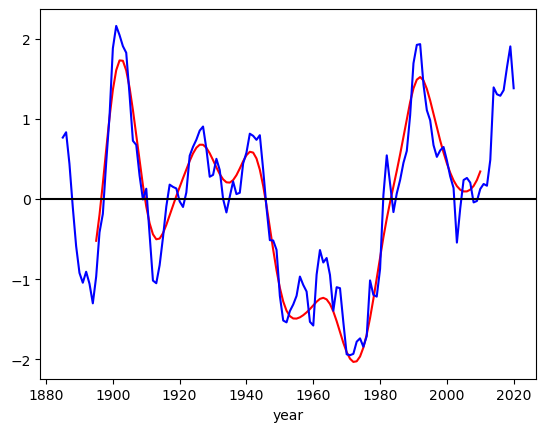

In [7]:
import matplotlib.pyplot as plt
TPI_filt.plot(c='r')
TPI_standard.plot(c='b')
plt.axhline(0, c='k')